In [12]:
import sys, os, numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx

sys.path.append(os.path.relpath("../../src/"))
from network import * # my class
import itertools
import pandas as pd
import numpy as np
import networkx as nx
import pylab as plt
from scipy.stats import norm,uniform,binom,poisson
import random
from functools import reduce
from collections import deque
import itertools
from uuid import uuid4
import seaborn as sns
import json 
from tqdm import tqdm
%matplotlib inline

In [13]:
class Station(Node):
    def __init__(self, name, x, y):
        super().__init__()
        self.name = name
        self.line = set()
        self.x = x
        self.y = y
        self.cardinal_cycle = itertools.cycle([(0,1),(1,0),(0,-1),(-1,0)])
        self.back_tracks = 0
        
    def __repr__(self):
        return f'({str(self.x)},{str(self.y)})' + " || " + self.name
    
    def __str__(self):
        return self.__repr__()
    
    def cardinal_move(self, dir, epsilon = 0.01):
        self.move(epsilon*dir[0], epsilon*dir[1], True)
        
    @classmethod
    def make(cls, name, x, y):
        return cls(name, x, y)
    
class Connection(Edge):
    def __init__(self, station1, station2, line):
        super().__init__(station1, station2)
        self.line = line
        self.weight = lambda x : Node.dist(x.node1,x.node2)
        
    def __repr__(self):
        return str(self.line) + " || " + self.node1.name + " =#=#=#=#=#= " + self.node2.name
    
    def __str__(self):
        return self.__repr__()
    
    @classmethod
    def make(cls, station1, station2, line):
        return cls(station1, station2, line)
    
    
class Metro(Network):
    def __init__(self, stations, connections):
        super().__init__(stations, connections)
    
    
    def station_MSE(self, station, target_length = 1):
        adj_edges = [edge for edges in (i['edge'] for i in self.adj[station.id].values() if i['edge']) for edge in edges]
        error_vector = [(self._edge_translator[edge].weight - target_length)**2 for edge in adj_edges]
        return (sum(error_vector)/len(error_vector))**0.5
    
    def station_move(self, station, epsilon = 0.01, max_back_tracks = 1000, target_length = 1):
        if station.back_tracks > max_back_tracks:
            return 'stuck'
        dir = next(station.cardinal_cycle)
        error = self.station_MSE(station, target_length)
        station.cardinal_move(dir, epsilon)
        if self.station_MSE(station, target_length) > error:
            station.back_tracks +=1
            station.cardinal_move(dir, -epsilon)
            return 
        station.back_tracks = 0
        return 
    
    def reset_back_tracks(self):
        for station in self.nodes:
            station.back_tracks = 0

In [14]:
with open('data_extraction/clean_metro_data.json', 'r') as fp: 
    line_dict = json.load(fp)
    line_dict = {int(key): value for key, value in line_dict.items()}

In [15]:
complete_lines = {}
for k in range(1,11):
    complete_lines[k] = []
    for i , j in enumerate(line_dict[k]):
        if j[1]:
            if j[1][0] >= k:
                complete_lines[k].append((k,i,1,line_dict[k][i][0]))
            else:
                val = reduce(lambda x,y : x if x[0] == j[0] else y,line_dict[j[1][0]])
                complete_lines[k].append((j[1][0],line_dict[j[1][0]].index(val),1,line_dict[k][i][0]))
        else:
            complete_lines[k].append((k,i,1,line_dict[k][i][0]))

In [16]:
stations = []
station_locs = []
connections = []
visited_stations = {}
name_to_station = {}
for i in range(1,11):
    path = complete_lines[i]
    for j in range(len(path)-1):
        loc1 = (path[j][0],path[j][1])
        loc2 = (path[j+1][0],path[j+1][1])
        
        if loc1 not in station_locs:
            station1 = Station.make(path[j][3],*loc1)
            station_locs.append(loc1)
            stations.append(station1)
            name_to_station[path[j][3]] = station1.id
            station1.line.add(i)
        else: 
            station1 = stations[station_locs.index(loc1)]
            station1.line.add(i)
            
            
        if loc2 not in station_locs:
            station2 = Station.make(path[j+1][3],*loc2)
            station_locs.append(loc2)
            stations.append(station2)
            name_to_station[path[j+1][3]] = station2.id
            station2.line.add(i)
        else:
            station2 = stations[station_locs.index(loc2)]
            station2.line.add(i)

        connections.append(Connection.make(station1,station2,i))


madrid_metro = Metro(stations,connections)

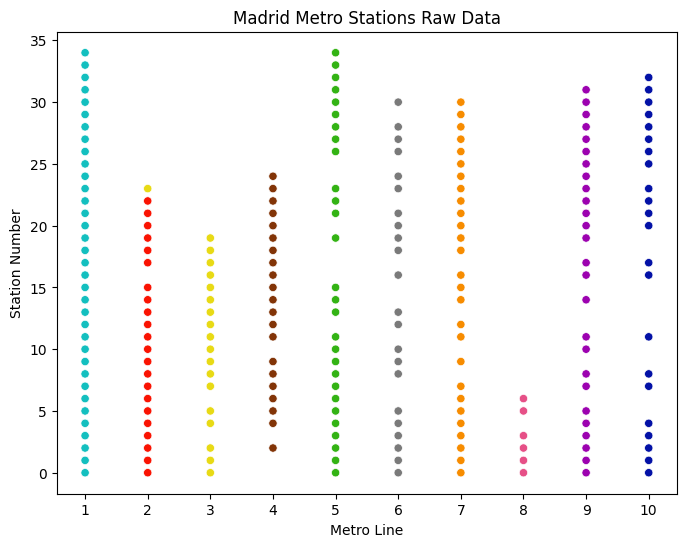

In [17]:
station_data_before_optimization = []
for i in madrid_metro.nodes:
    station_data_before_optimization.append([i.name,i.x,i.y,min(i.line)])
    
station_data_before_optimization = pd.DataFrame(station_data_before_optimization,columns = ['name','Latitude (rel.)','Longitude (rel.)','Metro Line'])
station_data_before_optimization.to_csv('result_images/station_data_before_optimization.csv',index = False)

palette ={1: "#13bfbf", 2: "#fa1302", 3: "#e8da15", 4: "#823407",5: "#33b314", 6: "#7a7a7a", 7: "#f78c00", 8: "#e65087", 9: "#9c02b0", 10: "#0311a6"}
plt.figure(figsize=(8,6))
sns.scatterplot(data=station_data_before_optimization, x='Latitude (rel.)', y='Longitude (rel.)', hue='Metro Line', palette=palette)
plt.xlabel('Metro Line')
plt.ylabel('Station Number')
plt.xticks([i for i in range(1,11)])
ax = plt.gca() 
ax.legend_= None
plt.title('Madrid Metro Stations Raw Data')
plt.savefig('result_images/station_data_raw.png')
plt.show()

In [18]:
with open('data_extraction/End_Stations_Coordinates_clean.json', 'r') as fp:
    end_coords = json.load(fp)

pile = madrid_metro.nodes[:]
for key, value in end_coords.items():
    x = name_to_station.get(key)
    y = madrid_metro._node_translator[x]
    pile.remove(y)
    y.move(value[0],value[1],rel=False)


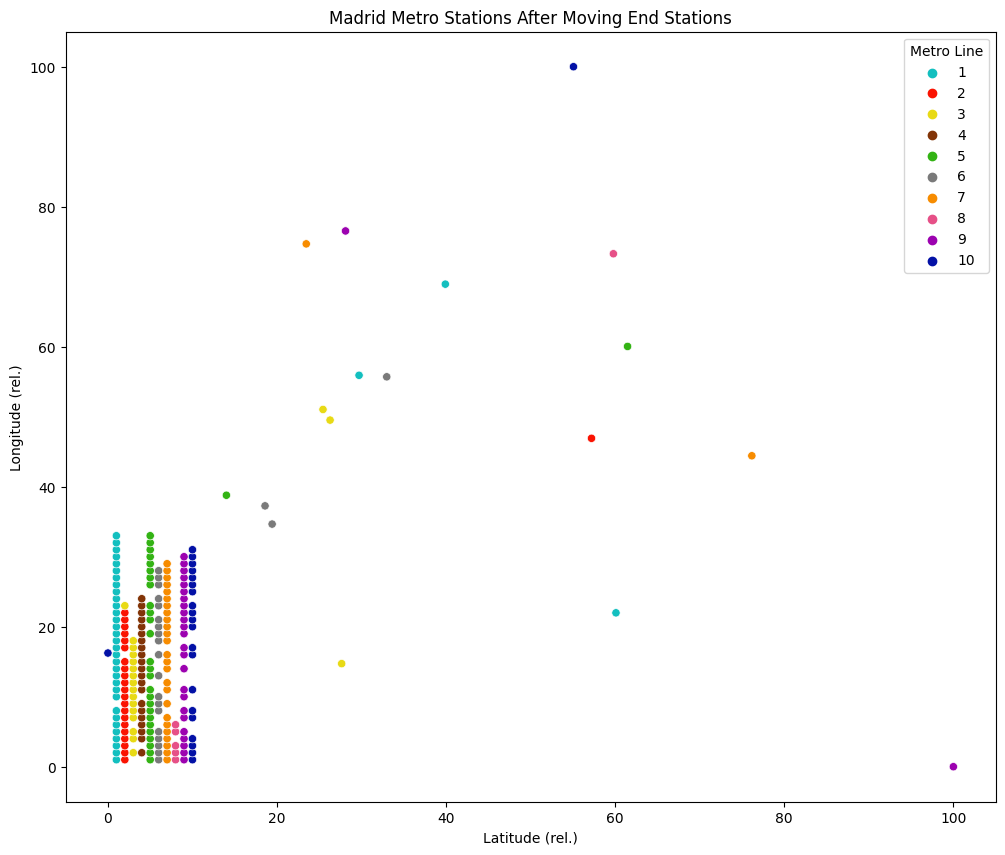

In [19]:
station_data_move_ends = []
for i in madrid_metro.nodes:
    station_data_move_ends.append([i.name,i.x,i.y,min(i.line)])
    
station_data_move_ends = pd.DataFrame(station_data_move_ends,columns = ['name','Latitude (rel.)','Longitude (rel.)','Metro Line'])
station_data_move_ends.to_csv('result_images/station_data_move_ends.csv',index = False)
plt.figure(figsize=(12,10))
sns.scatterplot(data=station_data_move_ends, x='Latitude (rel.)', y='Longitude (rel.)', hue='Metro Line', palette=palette)
plt.title('Madrid Metro Stations After Moving End Stations')
plt.savefig('result_images/station_data_move_ends.png')
plt.show()

In [20]:
pile_copy = pile[:]
madrid_metro.reset_back_tracks()

for i in tqdm(range(10000)):
    for station in pile_copy:
        x = madrid_metro.station_move(station,
                                      epsilon=0.05,
                                      max_back_tracks=1000,
                                      target_length=2)
        if x == 'stuck':
            pile_copy.remove(station)
            

100%|██████████| 10000/10000 [00:44<00:00, 226.01it/s]


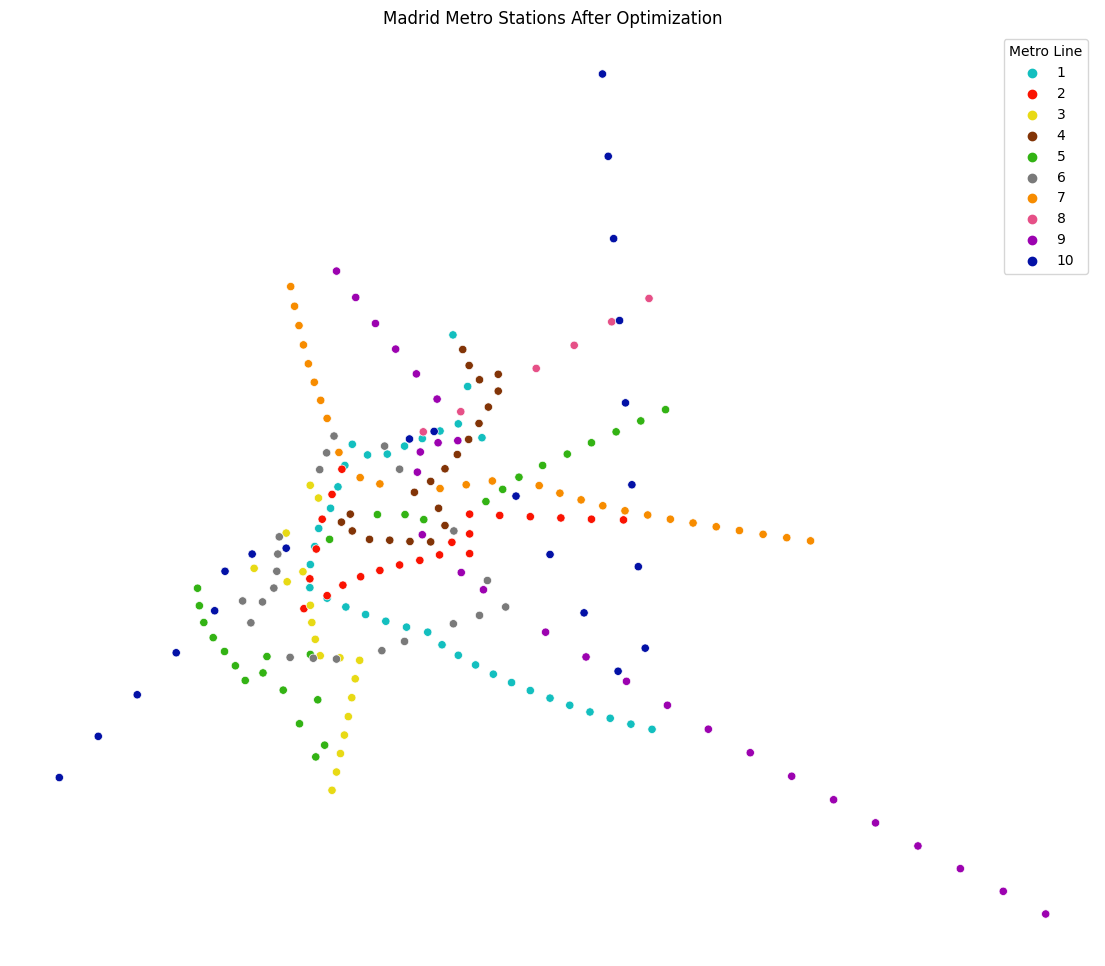

In [21]:
station_data_post_optimization = []
for i in madrid_metro.nodes:
    station_data_post_optimization.append([i.name,i.x,i.y,min(i.line)])
    
station_data_post_optimization = pd.DataFrame(station_data_post_optimization,columns = ['name','Latitude (rel.)','Longitude (rel.)','Metro Line'])
station_data_post_optimization.to_csv('result_images/station_data_post_optimization.csv',index = False)

plt.figure(figsize=(14,12))
ax = plt.gca()
ax.set_axis_off()
sns.scatterplot(data=station_data_post_optimization, x='Latitude (rel.)', y='Longitude (rel.)', hue='Metro Line', palette=palette)
plt.title('Madrid Metro Stations After Optimization')
plt.savefig('result_images/station_data_post_optimization.png')
plt.show()

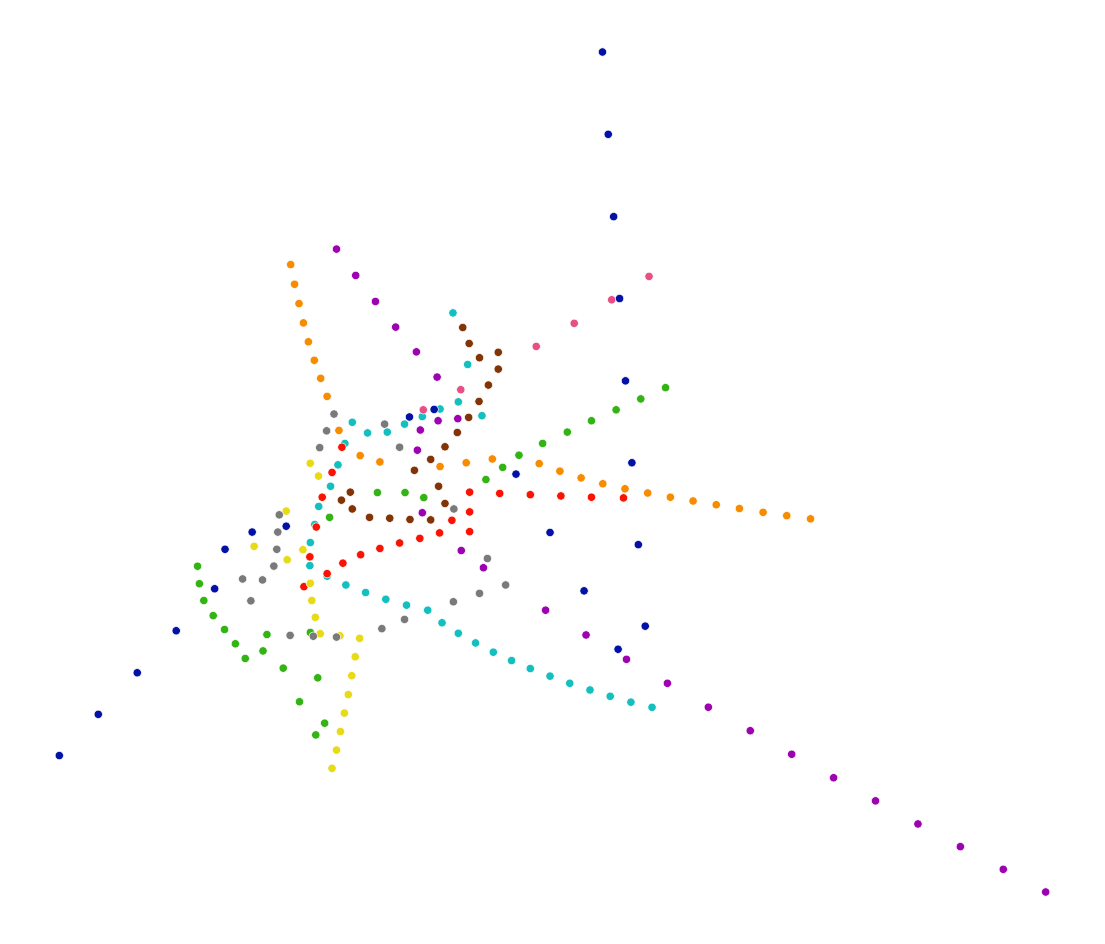

In [22]:
# Transparent Background
plt.figure(figsize=(14,12))

ax = plt.gca()
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0)
plt.rcParams.update({
    "figure.facecolor":  (0.5,0.5, 0.5, 0.2),  # red   with alpha = 30%
    "savefig.facecolor": (0.5,0.5, 0.5, 0.2),  # blue  with alpha = 20%
})
ax.set_axis_off()
sns.scatterplot(data=station_data_post_optimization, x='Latitude (rel.)', y='Longitude (rel.)', hue='Metro Line', palette=palette)

plt.legend('',frameon=False)
plt.savefig('result_images/station_data_post_optimization_transparent.png')
plt.show()